In [1]:
!pip install pennylane

In [2]:
# Importowanie bibliotek
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [3]:
# Ustawienie ziarna losowości
np.random.seed(42)

In [4]:
# Wczytanie danych (zbior odręcznych cyfr z sklearn)
data = datasets.load_digits()
images = data['images']
targets = data['target']

In [6]:
# Skalowanie pikseli (standaryzacja do [0, 1])
images = images / 16.0

In [7]:
# Podział danych na zbiory treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.25, random_state=42)

In [8]:
# Spłaszczenie obrazów (wektory 64-elementowe)
X_train = X_train.reshape(-1, 64)
X_test = X_test.reshape(-1, 64)

In [9]:
# Ustawienie parametrów kwantowego systemu
n_qubits = 6  # Liczba kubitów (może być mniejsza niż liczba cech, dlatego zredukujemy dane)
dev = qml.device("default.qubit", wires=n_qubits)

In [10]:
# Funkcja kodowania danych w przestrzeni kwantowej
def encode_data(x):
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)

In [11]:
# Kwantowy ansatz (obwód parametryczny)
def variational_circuit(weights):
    for i in range(n_qubits):
        qml.RX(weights[i], wires=i)
        qml.RZ(weights[i], wires=i)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])

In [12]:
# Kwantowy obwód złożony z kodowania i ansatza
@qml.qnode(dev)
def quantum_circuit(params, x):
    encode_data(x)
    variational_circuit(params)
    return qml.expval(qml.PauliZ(0))

In [13]:
# Funkcja kosztu dla klasy k
def cost(params, X, y, target_class):
    y_binary = (y == target_class).astype(float)
    predictions = [quantum_circuit(params, x) for x in X]
    return np.mean((np.array(predictions) - y_binary) ** 2)


In [14]:
# Trenowanie modeli dla każdej klasy
num_classes = 10
params_list = []
opt = qml.GradientDescentOptimizer(stepsize=0.1)
num_epochs = 30

for target_class in range(num_classes):
    print(f"\nTraining quantum model for class {target_class}")
    params = np.random.uniform(low=-np.pi, high=np.pi, size=(n_qubits,))
    losses = []

    for epoch in range(num_epochs):
        params = opt.step(lambda p: cost(p, X_train, y_train, target_class), params)
        current_loss = cost(params, X_train, y_train, target_class)
        losses.append(current_loss)
        print(f"Epoch {epoch+1}: Loss = {current_loss:.4f}")

    params_list.append(params)


Training quantum model for class 0
Epoch 1: Loss = 0.7987
Epoch 2: Loss = 0.6098
Epoch 3: Loss = 0.4812
Epoch 4: Loss = 0.3980
Epoch 5: Loss = 0.3455
Epoch 6: Loss = 0.3122
Epoch 7: Loss = 0.2910
Epoch 8: Loss = 0.2774
Epoch 9: Loss = 0.2685
Epoch 10: Loss = 0.2625
Epoch 11: Loss = 0.2586
Epoch 12: Loss = 0.2559
Epoch 13: Loss = 0.2541
Epoch 14: Loss = 0.2528
Epoch 15: Loss = 0.2519
Epoch 16: Loss = 0.2513
Epoch 17: Loss = 0.2509
Epoch 18: Loss = 0.2506
Epoch 19: Loss = 0.2504
Epoch 20: Loss = 0.2502
Epoch 21: Loss = 0.2501
Epoch 22: Loss = 0.2501
Epoch 23: Loss = 0.2500
Epoch 24: Loss = 0.2500
Epoch 25: Loss = 0.2499
Epoch 26: Loss = 0.2499
Epoch 27: Loss = 0.2499
Epoch 28: Loss = 0.2499
Epoch 29: Loss = 0.2499
Epoch 30: Loss = 0.2499

Training quantum model for class 1
Epoch 1: Loss = 0.2499
Epoch 2: Loss = 0.2499
Epoch 3: Loss = 0.2499
Epoch 4: Loss = 0.2499
Epoch 5: Loss = 0.2499
Epoch 6: Loss = 0.2499
Epoch 7: Loss = 0.2499
Epoch 8: Loss = 0.2499
Epoch 9: Loss = 0.2499
Epoch 10: 

In [17]:
# Predykcja dla danych testowych
def predict(X):
    all_preds = np.array([[quantum_circuit(params, x) for params in params_list] for x in X])
    return np.argmax(all_preds, axis=1)


In [18]:
# Ewaluacja modelu
y_pred = predict(X_test)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))



Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        46
           1       0.49      1.00      0.66        44

    accuracy                           0.49        90
   macro avg       0.24      0.50      0.33        90
weighted avg       0.24      0.49      0.32        90



C:\Users\blaze\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\blaze\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\blaze\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


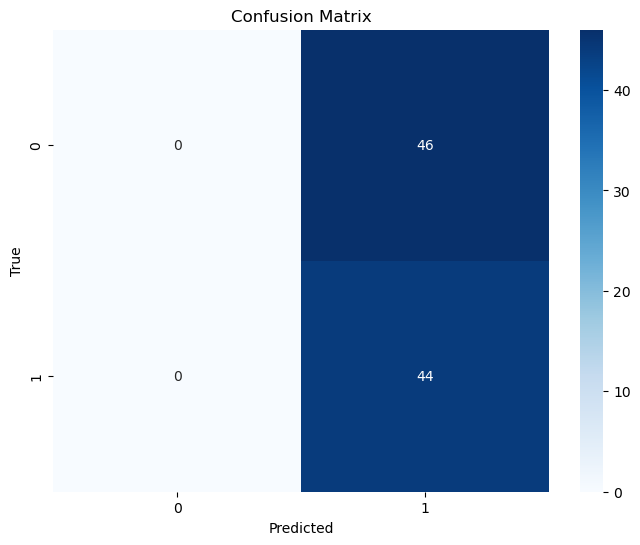

In [19]:
# Macierz konfuzji
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()